# Written by Abdul (https://github.com/aadinoyiibrahim) on 16.10.2024. If you encounter any difficulties, feel free to reach out!"

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:10]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-scans/pituitary/0664.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1269.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0733.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0106.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0375.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1700.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1075.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0285.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0591.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0799.jpg
/kaggle/input/brain-tumor-mri-scans/healthy/0664.jpg
/kaggle/input/brain-tumor-mri-scans/healthy/1269.jpg
/kaggle/input/brain-tumor-mri-scans/healthy/0733.jpg
/kaggle/input/brain-tumor-mri-scans/healthy/0106.jpg
/kaggle/input/brain-tumor-mri-scans/healthy/0375.jpg
/kaggle/input/brain-tumor-mri-scans/healthy/1700.jpg
/kaggle/input/brain-tumor-mri-scans/healthy/1786.jpg
/kaggle/input/brain-tumor-mri-scans/healthy/1075.jpg
/kaggle/input/brain-tumor-

# About Dataset 
There a total of 7023 MRI scans of brains split into four classes. Transfer learning and CNNs could be used for classifying these images, which could save patient lives through early tumor diagnosis.

Data source: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans/data

### 

# Table of Contents

1. [Import necessary libraries](#import-necessary-libraries)
2. [dataset: loading and overview](#load-the-dataset)
3. [Model Building](#data-splitting)
   - [DenseNet121(model 1)](#DenseNet121)
   - [DenseNet121(model 2)](#DenseNet121v2)
   - [Evaluation](#visualize-metrics)
   - [Test Performance Comparison of Models](#Test-Performance-Comparison)
   - [Predict & display](#predict-n-display)
4. [Conclusion](#conclusion)


In [13]:
# import-necessary-libraries

import numpy as np
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import os
import cv2
import random

from PIL import Image # for image

import tensorflow as tf
import keras 
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow import keras
from tensorflow.keras import layers, regularizers, models, optimizers
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import array_to_img

import warnings
warnings.filterwarnings('ignore')

In [14]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.4.0
True


# load-the-dataset

In [15]:
# load-the-dataset
# Define image data path
image_data_dir = '/kaggle/input/brain-tumor-mri-scans'

# Gather all file paths using glob
train_files = glob.glob(os.path.join(image_data_dir, '*', '*'))

# Shuffle the file list using random.shuffle for better performance
random.shuffle(train_files)

# Extract labels from the file paths (assuming label is the folder name)
train_labels = [os.path.basename(os.path.dirname(file)) for file in train_files]

# Create the DataFrame with the image paths and corresponding labels
train_df = pd.DataFrame({
    'image': train_files,
    'label': train_labels
})

train_df


,image,label
0,/kaggle/input/brain-tumor-mri-scans/pituitary/...,pituitary
1,/kaggle/input/brain-tumor-mri-scans/glioma/126...,glioma
2,/kaggle/input/brain-tumor-mri-scans/healthy/17...,healthy
3,/kaggle/input/brain-tumor-mri-scans/healthy/18...,healthy
4,/kaggle/input/brain-tumor-mri-scans/pituitary/...,pituitary
...,...,...
7018,/kaggle/input/brain-tumor-mri-scans/meningioma...,meningioma
7019,/kaggle/input/brain-tumor-mri-scans/pituitary/...,pituitary
7020,/kaggle/input/brain-tumor-mri-scans/pituitary/...,pituitary
7021,/kaggle/input/brain-tumor-mri-scans/pituitary/...,pituitary


In [16]:
train_labels[:10]

['pituitary',
 'glioma',
 'healthy',
 'healthy',
 'pituitary',
 'healthy',
 'healthy',
 'healthy',
 'pituitary',
 'healthy']

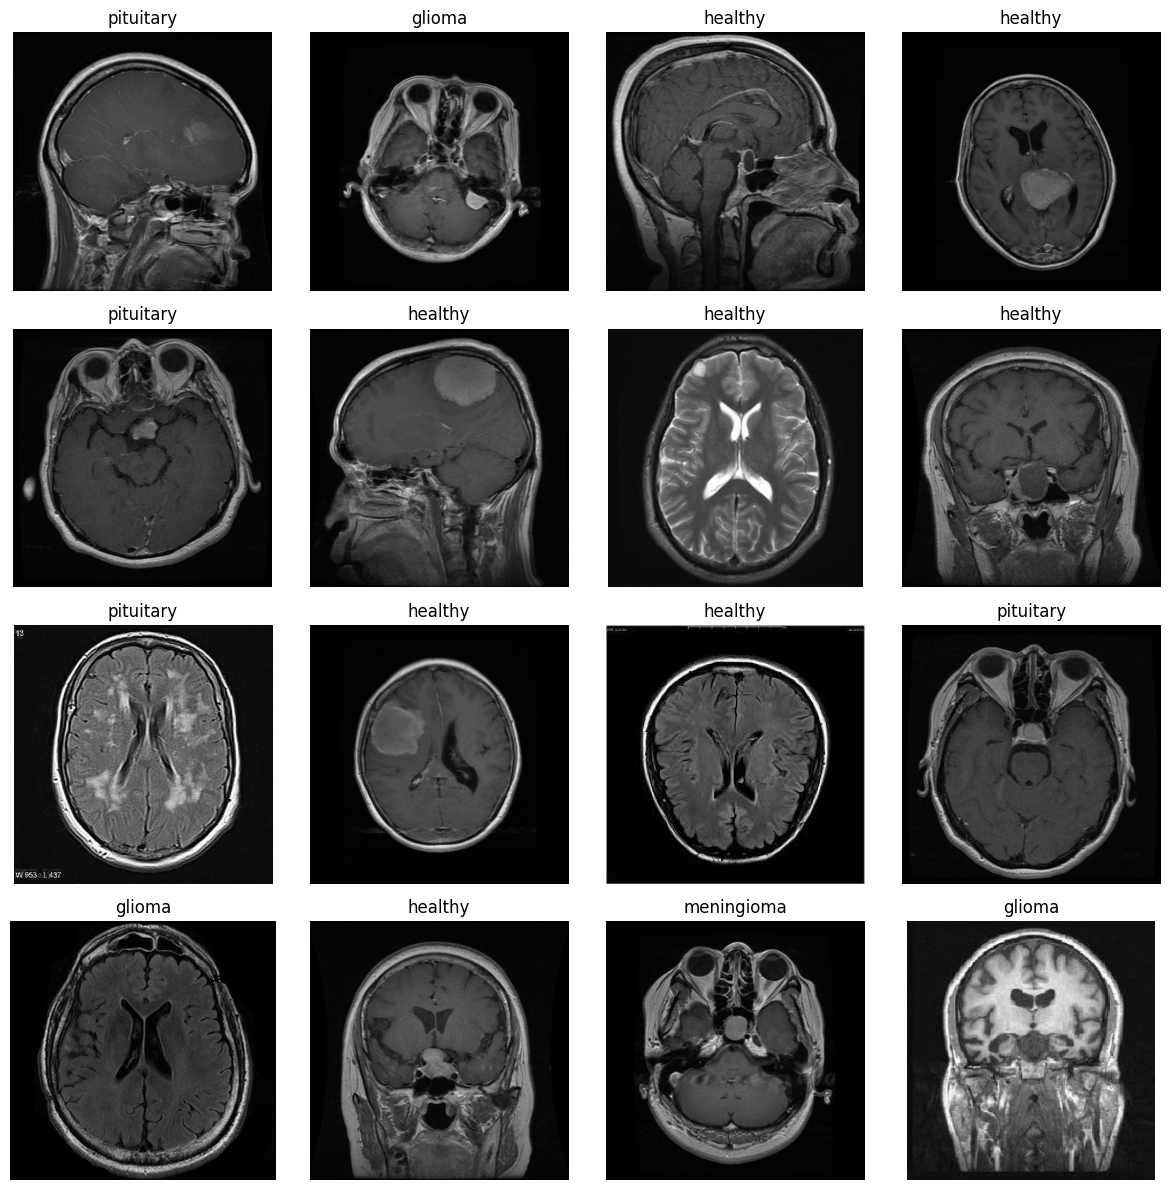

In [17]:

num_images = 16 # number of images to display
sample_images = train_df.sample(num_images)['image'].values # random sample of images


fig, axes = plt.subplots(4, 4, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.2) # spacing between images

for i, ax in enumerate(axes.flat):
    # Open the image file
    img = Image.open(sample_images[i])
    ax.imshow(img) # display images
    ax.set_title(train_labels[i]) # set title
    ax.axis('off') # Remove axis labels for a cleaner look
plt.tight_layout()
plt.show()


In [18]:
# unique train labels

np.unique(train_labels)

array(['glioma', 'healthy', 'meningioma', 'pituitary'], dtype='<U10')

In [19]:
# Variable setup
batch_size = 8
target_size = (224, 224)
validation_split = 0.2
test_split = 0.1

# Load all data
all_data = tf.keras.preprocessing.image_dataset_from_directory(
            image_data_dir,
            image_size=target_size,
            batch_size=batch_size,
            shuffle=True,  # Shuffle to ensure randomness in splits
        )

# Calculate the sizes for splitting the dataset
dataset_size = tf.data.experimental.cardinality(all_data).numpy()
train_size = int(dataset_size * (1 - validation_split - test_split))
validation_size = int(dataset_size * validation_split)

# Split the dataset into train, validation, and test sets
train_dataset = all_data.take(train_size)
remaining_data = all_data.skip(train_size)
validation_dataset = remaining_data.take(validation_size)
test_dataset = remaining_data.skip(validation_size)

Found 7023 files belonging to 4 classes.


# Splitting the data

In [20]:
# data-splitting
# Get the size of the complete dataset
dataset_size = tf.data.experimental.cardinality(all_data).numpy()

# Get the sizes of the datasets
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
validation_size = tf.data.experimental.cardinality(validation_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

# Calculate the proportions
train_proportion = train_size / dataset_size
validation_proportion = validation_size / dataset_size
test_proportion = test_size / dataset_size

# proportion
print(f"Train dataset proportion: {train_proportion:.2%}")
print(f"Validation dataset proportion: {validation_proportion:.2%}")
print(f"Test dataset proportion: {test_proportion:.2%}")

Train dataset proportion: 69.93%
Validation dataset proportion: 19.93%
Test dataset proportion: 10.14%


# Model implementation
let's implement 2 models:
## Model 1 - DenseNet121


In [21]:
# DenseNet121

weight_dir = '/kaggle/input/densenet121-weights-tf/tensorflow2/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5/1/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
input_shape = (224, 224, 3)
DenseNet121_model = tf.keras.applications.DenseNet121(input_shape = input_shape,
                                 include_top = False, # Exclude the final classification layer
                                 weights = weight_dir #'imagenet' # Use ImageNet pre-trained weights
                            )

DenseNet121_model.trainable = False

# Build the Sequential model
model1 = keras.Sequential([
    DenseNet121_model,
    keras.layers.GlobalAveragePooling2D(),  # Replace the flattened feature map with a single global average pooling layer
    keras.layers.Dense(128, activation='relu'),  # Dense layer with 128 units and ReLU activation
    keras.layers.Dropout(0.5),  # Dropout layer for regularization
    keras.layers.Dense(4, activation='softmax')  # Final classification layer with 4 output classes
])

# Display the model summary
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

This model is built using **DenseNet121**, a pre-trained convolutional neural network (CNN) adapted for a custom image classification task. The model takes 224x224 RGB images as input and uses pre-trained weights from a custom directory. DenseNet121 is frozen, meaning its weights are not updated during training, and serves as a feature extractor.

A custom classification head is added on top of DenseNet121, consisting of:

 -   GlobalAveragePooling2D: Reduces the output of DenseNet121.
 -   Dense Layer (128 units, ReLU): Adds a fully connected layer for further feature extraction.
 -   Dropout (0.5): Regularizes the model to prevent overfitting.
 -   Final Dense Layer (4 units, Softmax): Outputs class probabilities for 4 target classes.

The model has 7.16 million parameters, but only 131,716 are trainable, as most belong to the frozen DenseNet121. This approach leverages transfer learning by fine-tuning only the added layers, making the model efficient for classification tasks.

In [22]:
# Define callbacks more explicitly for better control
callbacks = [
    ModelCheckpoint("densent121_model.keras", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
    ]

# Compile the model with specified learning rate for Adam optimizer
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Set learning rate for Adam optimizer
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Fit the model with the specified callbacks
hist1 = model1.fit(
    train_dataset,  
    epochs = 50,
    validation_data = validation_dataset,  
    callbacks = callbacks
)


Epoch 1/50


I0000 00:00:1729086338.756969     131 service.cc:145] XLA service 0x7b60d4003370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729086338.757027     131 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  6/614 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.3441 - loss: 5.8502 

I0000 00:00:1729086350.510719     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


614/614 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - accuracy: 0.4123 - loss: 2.4028 - val_accuracy: 0.7557 - val_loss: 0.7478
Epoch 2/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6575 - loss: 0.8628 - val_accuracy: 0.7843 - val_loss: 0.6138
Epoch 3/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7252 - loss: 0.7221 - val_accuracy: 0.8136 - val_loss: 0.5496
Epoch 4/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.7502 - loss: 0.6571 - val_accuracy: 0.8350 - val_loss: 0.4845
Epoch 5/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8005 - loss: 0.5480 - val_accuracy: 0.8343 - val_loss: 0.4697
Epoch 6/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.8031 - loss: 0.5278 - val_accuracy: 0.8471 - val_loss: 0.4320
Epoch 7/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.8203 - loss: 0.4981 - val_accuracy: 0.8464 - val_loss: 0.4180
Epoch 8/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8275 - loss: 0.4753 - val_accurac

## Model 2 :

In [23]:
# DenseNet121v2

# Define the model using DenseNet121
DenseNet121_model2 = tf.keras.applications.DenseNet121(
                        input_shape = input_shape,
                        include_top = False,
                        weights = weight_dir
                    )

# Freeze all layers, and then unfreeze only the last 30 layers for fine-tuning
for layer in DenseNet121_model2.layers[:-30]:
    layer.trainable = False

# Sequential model on top of DenseNet121
model2 = models.Sequential([
    DenseNet121_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation=None, kernel_regularizer=regularizers.l2(0.01)),  # Increased Dense units
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.01)),  # Added another Dense layer
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation=tf.nn.softmax)  # 4 classes with softmax
])

# Print the summary of the model
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 641,408 (2.45 MB)

 Non-trainable params: 6,396,096 (24.40 MB)

This model is built using **DenseNet121**, a pre-trained convolutional neural network (CNN), adapted for a custom image classification task. The model takes 224x224 RGB images as input and uses pre-trained weights from a custom directory (I download and uploaded on Kaggle). The majority of DenseNet121’s layers are frozen to preserve pre-trained knowledge, but the last 30 layers are unfrozen to allow for fine-tuning, enabling the model to adjust to the specific task while maintaining the benefits of transfer learning.

A custom classification head is added on top of DenseNet121, consisting of:

 -   GlobalAveragePooling2D: Reduces the output of DenseNet121 into a single 1024-dimensional vector.
 -   Dense Layer (256 units, L2 Regularization): A fully connected layer with 256 units, L2 regularization, followed by BatchNormalization and ReLU activation for feature extraction.
 -   Dropout (0.5): Adds dropout to prevent overfitting.
 -   Dense Layer (128 units, L2 Regularization): Another dense layer with 128 units, regularized by L2, followed by BatchNormalization and ReLU activation.
 -   Final Dense Layer (4 units, Softmax): Outputs class probabilities for 4 target classes using softmax activation.

This model uses fine-tuning by allowing only the last 30 layers of DenseNet121 to be trainable, while the rest remain frozen. 

In [24]:
# Learning rate scheduler function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
# Compile the model with advanced optimizer settings
model2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Learning rate can be tuned
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    ModelCheckpoint("densent121_model2.keras", save_best_only=True, monitor="val_loss", mode="min"),
    EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    #LearningRateScheduler(lr_schedule)  
]

# Train the model with the callbacks
hist2 = model2.fit(
    train_dataset,  
    epochs = 50,
    validation_data = validation_dataset,  
    callbacks = callbacks
)


Epoch 1/50
  3/614 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.2778 - loss: 7.9216   

I0000 00:00:1729087418.686116     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_7', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_6', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_4', 4 bytes spill stores, 12 bytes spill loads



614/614 ━━━━━━━━━━━━━━━━━━━━ 63s 52ms/step - accuracy: 0.4536 - loss: 6.3149 - val_accuracy: 0.7943 - val_loss: 4.1531
Epoch 2/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.6936 - loss: 4.2881 - val_accuracy: 0.8700 - val_loss: 3.5124
Epoch 3/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7789 - loss: 3.6630 - val_accuracy: 0.9121 - val_loss: 3.0404
Epoch 4/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8240 - loss: 3.2057 - val_accuracy: 0.9271 - val_loss: 2.6615
Epoch 5/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8542 - loss: 2.8094 - val_accuracy: 0.9364 - val_loss: 2.3248
Epoch 6/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8583 - loss: 2.4489 - val_accuracy: 0.9450 - val_loss: 2.0160
Epoch 7/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8947 - loss: 2.1034 - val_accuracy: 0.9479 - val_loss: 1.7558
Epoch 8/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9048 - loss: 1.8075 - val_accurac

# visualize metrics

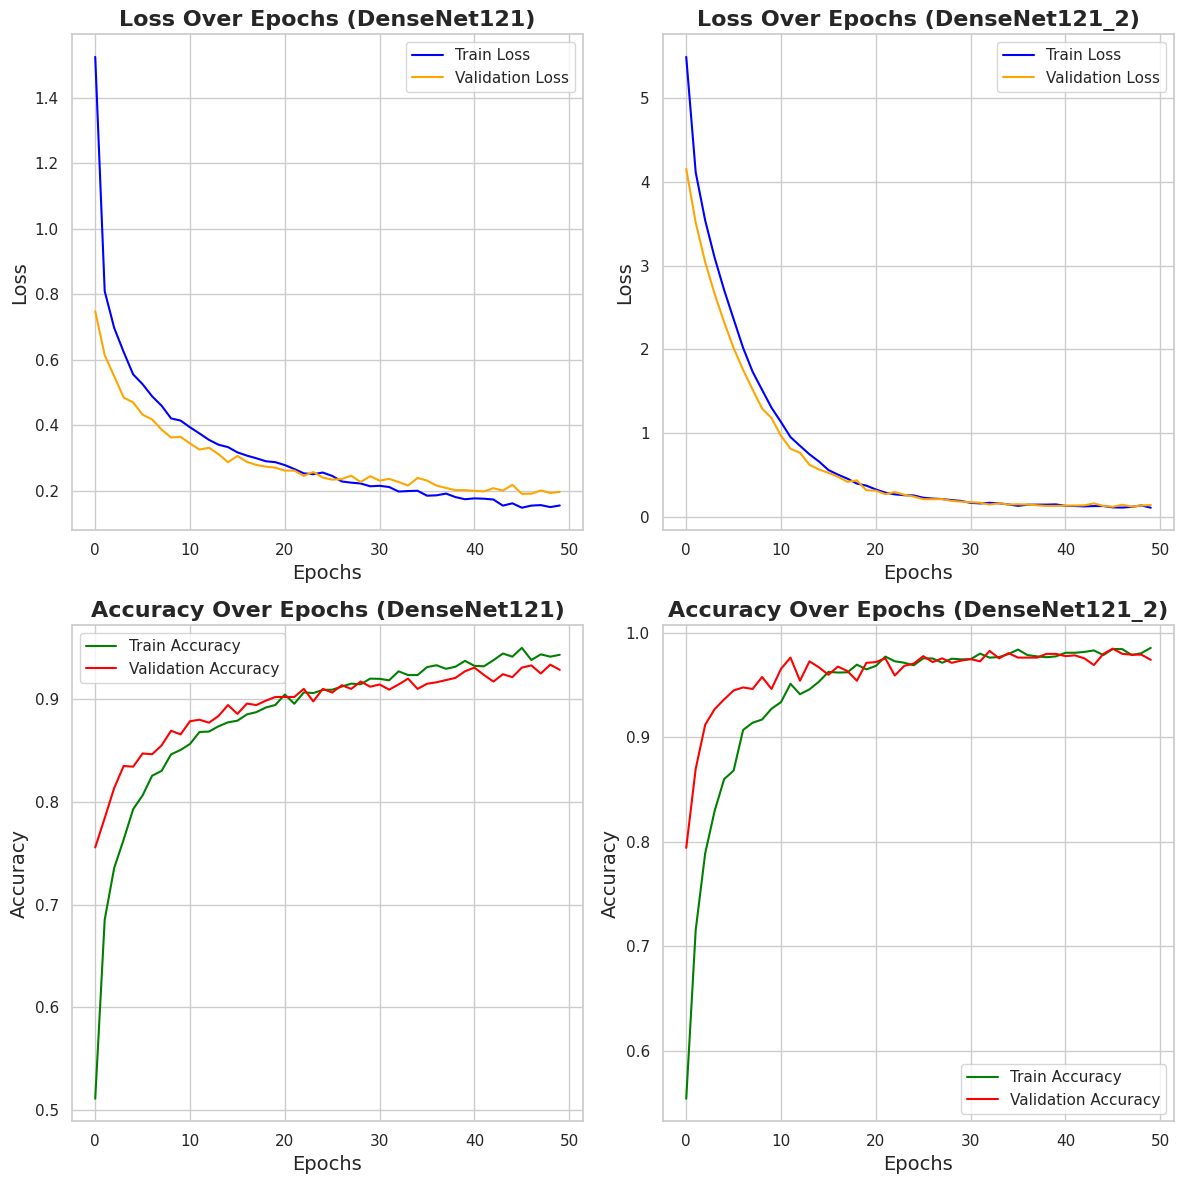

In [25]:
# visualize-metrics

def plot_model_comparison(histories, model_names=("Model 1", "Model 2")):
    sns.set(style="whitegrid")

    # Define metrics to plot and their corresponding titles and labels
    metrics = [('loss', 'Loss'), ('accuracy', 'Accuracy')]
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))  
  
    for i, (history, model_name) in enumerate(zip(histories, model_names)):
        for j, (metric, label) in enumerate(metrics):
            # Plot for train and validation metrics
            axs[j, i].plot(history.history[metric], label=f'Train {label}', color='blue' if label == 'Loss' else 'green')
            axs[j, i].plot(history.history[f'val_{metric}'], label=f'Validation {label}', color='orange' if label == 'Loss' else 'red')
            axs[j, i].set_title(f'{label} Over Epochs ({model_name})', fontsize=16, weight='bold')
            axs[j, i].set_xlabel('Epochs', fontsize=14)
            axs[j, i].set_ylabel(label, fontsize=14)
            axs[j, i].legend()
            axs[j, i].grid(True)

    plt.tight_layout()
    plt.show()


plot_model_comparison([hist1, hist2], model_names=("DenseNet121", "DenseNet121_2"))


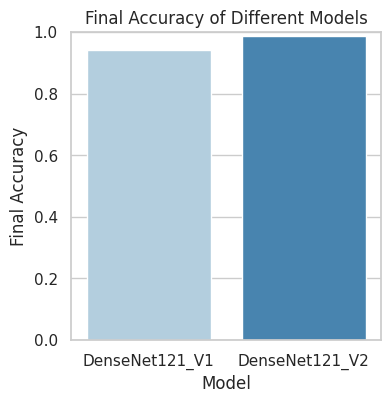

In [26]:
# Final Accuracy Comparison of Models

last_acc1 = hist1.history['accuracy'][-1]
last_acc2 = hist2.history['accuracy'][-1]
data = {
    'Model': ['DenseNet121_V1', 'DenseNet121_V2'],
    'Final Accuracy': [last_acc1, last_acc2]
}

df = pd.DataFrame(data)

plt.figure(figsize=(4, 4))
sns.barplot(x='Model', y='Final Accuracy', data=df, palette='Blues')
plt.xlabel('Model')
plt.ylabel('Final Accuracy')
plt.title('Final Accuracy of Different Models')
plt.ylim(0, 1)  

plt.show()

# Test Performance Comparison

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.9225 - loss: 0.1855
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9849 - loss: 0.1242


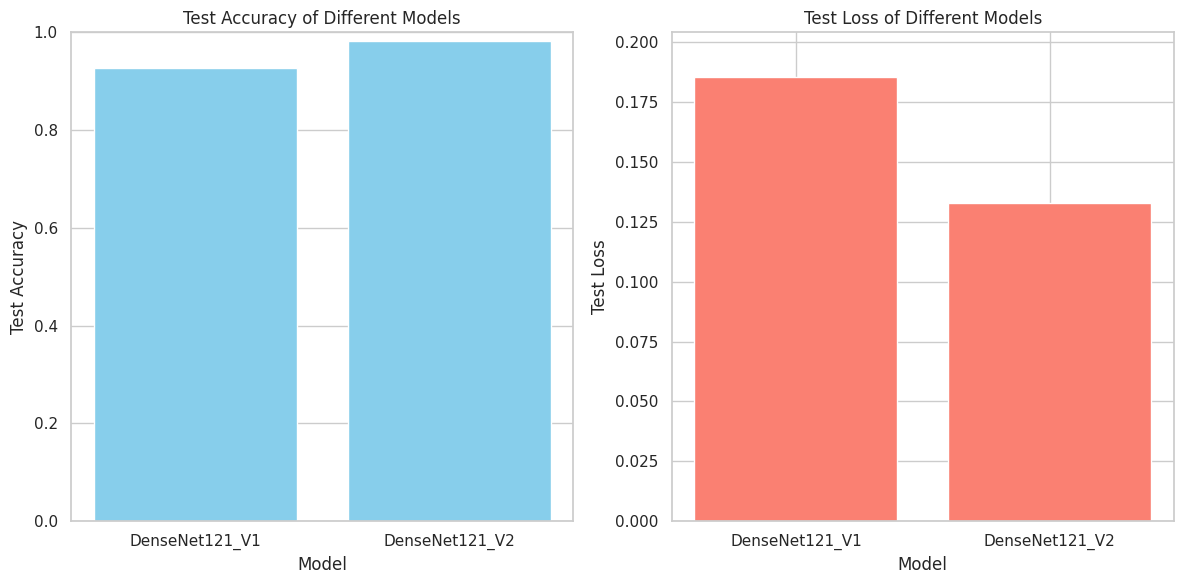

In [27]:
#Test-Performance-Comparison

# test dataset
models = [model1, model2]
model_names = ['DenseNet121_V1', 'DenseNet121_V2']

# Lists to store evaluation results
test_scores = []
test_accuracies = []

# Evaluate each model
for model in models:
    test_score, test_acc = model.evaluate(test_dataset)
    test_scores.append(test_score)  
    test_accuracies.append(test_acc)  

# Create a DataFrame for the results
data = {
    'Model': model_names,
    'Test Loss': test_scores,
    'Test Accuracy': test_accuracies
}
df = pd.DataFrame(data)

# Visualize accuracy
plt.figure(figsize=(12, 6))

# Create bar chart for Test Accuracy
plt.subplot(1, 2, 1)
plt.bar(df['Model'], df['Test Accuracy'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of Different Models')
plt.ylim(0, 1)  
plt.grid(axis='x')

# Create bar chart for Test Loss
plt.subplot(1, 2, 2)
plt.bar(df['Model'], df['Test Loss'], color='salmon')
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.title('Test Loss of Different Models')
plt.ylim(0, max(df['Test Loss']) * 1.1)  # Set y-axis range

# Display the charts
plt.tight_layout()
plt.show()

# Predict and display

using Model 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


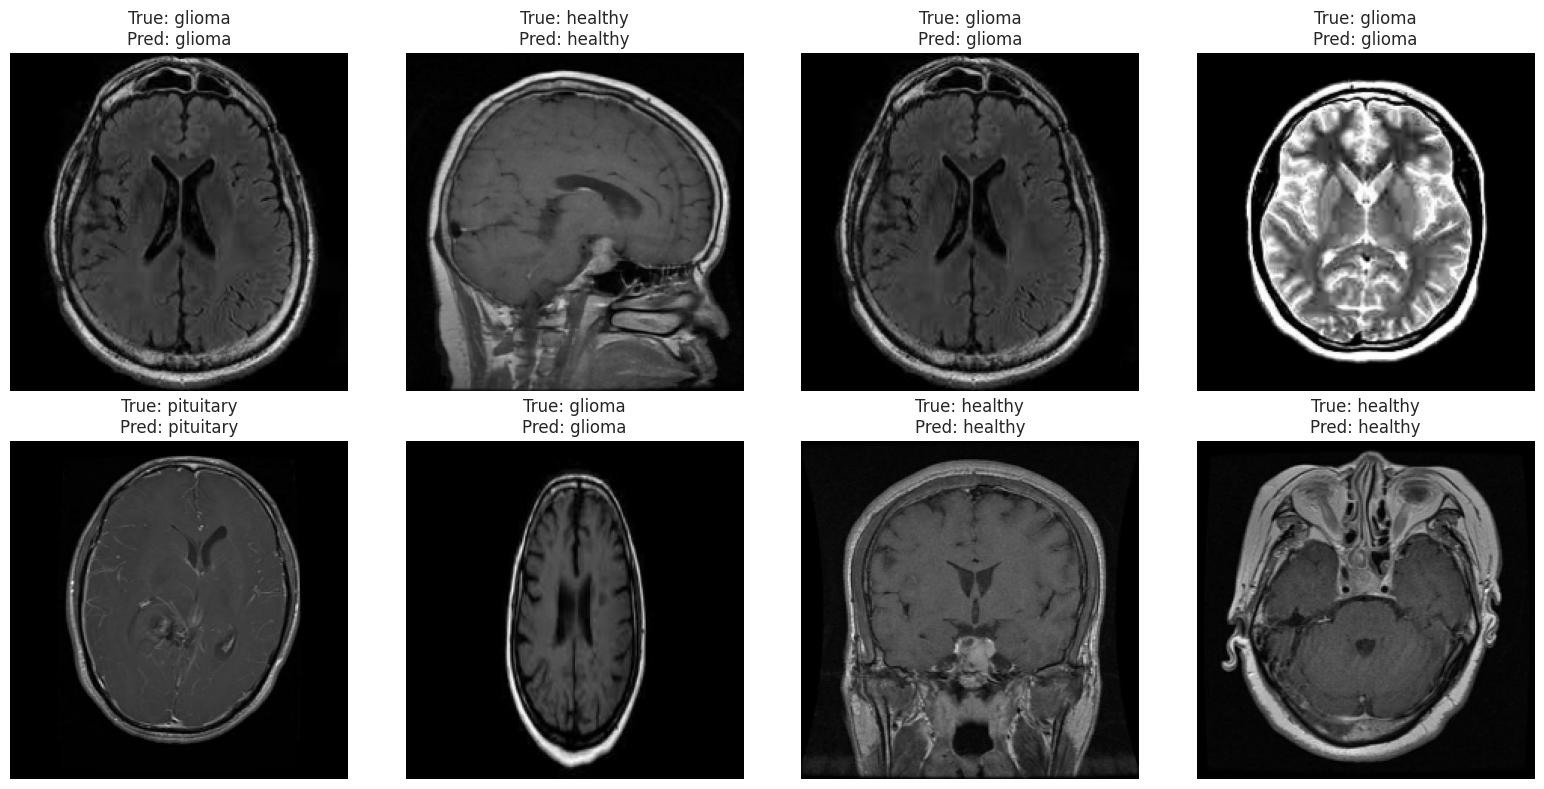

In [28]:
# predict-n-display
# from tensorflow.keras.preprocessing.image import array_to_img

def predict_and_display_images(model, dataset, class_names, num_images=8):
    # Select a batch of images from the test dataset
    image_batch, label_batch = next(iter(dataset.take(1)))  # Get a single batch of images
    image_batch = image_batch[:num_images]
    label_batch = label_batch[:num_images]
    
    # Make predictions on the batch
    predictions = model.predict(image_batch)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Plot the images with predicted and true labels
    plt.figure(figsize=(16, 8))
    for i in range(num_images):
        ax = plt.subplot(2, 4, i + 1)
        img = array_to_img(image_batch[i])  # Convert back to a displayable image format
        plt.imshow(img)
        true_label = class_names[label_batch[i]]
        predicted_label = class_names[predicted_classes[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage:
print("using Model 1:")
predict_and_display_images(model1, test_dataset, class_names=train_labels, num_images=8)


using Model 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


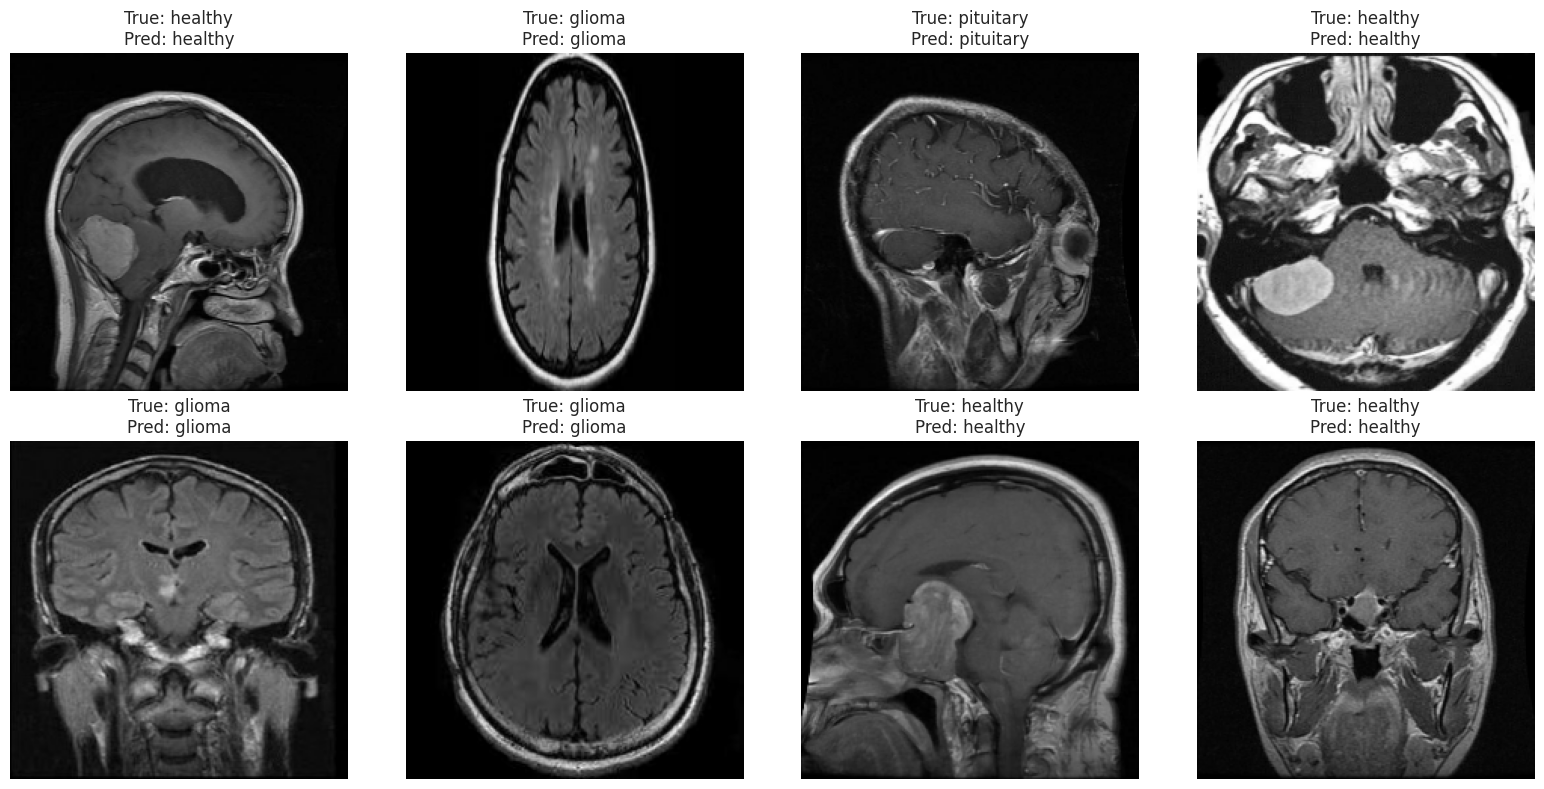

In [29]:
print("using Model 2:")
predict_and_display_images(model2, test_dataset, class_names=train_labels, num_images=8)


Both models, Model1 and Model2, were evaluated on the test set. Based on the two plots shown above, the following observations were made: Model1 and Model2 correctly correctly predicting all 8 images.

These results suggest that while both models perform well. Further evaluation on a larger test set might be necessary to confirm this performance difference.

-------------------------------------------------------------------------------

# Summary & Conclusion
This project focused on building and fine-tuning a deep learning model for brain tumor classification using transfer learning. The process involved data preparation, model implementation, training, evaluation, and visualization of the results.

1. Data Preparation and Splitting:

The dataset consists of brain tumor MRI scans, which were used for a multi-class classification task. The data was loaded and processed into appropriate formats using tf.keras.preprocessing.image_dataset_from_directory, ensuring that images were resized to 224x224 and batched efficiently.

The dataset was split into three parts:

  -  Training set: 70% of the data, used for model training.
   - Validation set: 20% of the data, used to monitor the model's performance during training and help prevent overfitting.
   - Test set: 10% of the data, used for final evaluation after training.

2. Model Implementation:

The core of the model was built using DenseNet121, a pre-trained convolutional neural network (CNN) from the Keras library, specifically chosen for its excellent performance in image classification tasks. The model was adapted for the brain tumor classification task as follows:

   - Transfer Learning: DenseNet121 was used as the feature extractor, pre-trained on the ImageNet dataset, with the final classification layer removed. Two configurations were explored:
   - Freezing DenseNet121: In the initial models, the entire DenseNet121 model was frozen, ensuring that only the newly added layers were trainable.
   - Fine-Tuning DenseNet121: In subsequent models, only the last 30 layers of DenseNet121 were unfrozen to allow for fine-tuning, making it possible for the model to adapt to the specifics of the brain tumor dataset.

A custom classification head was added on top of DenseNet121, which included:

 -   GlobalAveragePooling2D: To reduce the output of DenseNet121.
 -  Dense layers: Fully connected layers with 128 or 256 units, ReLU activation, and L2 regularization to enhance the model's learning capacity while avoiding overfitting.
 -   Dropout (0.5): To regularize the model and prevent overfitting by randomly dropping neurons during training.
 -  Final Dense layer: With 4 units and softmax activation to predict probabilities for the 4 output classes (e.g., tumor or non-tumor).

3. Training and Callbacks:

The model was compiled with the Adam optimizer and sparse categorical crossentropy loss to handle the multi-class classification problem. Several advanced techniques were incorporated during training:

 -   EarlyStopping: To stop training if the validation performance did not improve after a set number of epochs, thereby preventing overfitting.
 -   ModelCheckpoint: To save the model at the point where it performed best on the validation data, ensuring that the best version was kept for final evaluation.
 -   Learning Rate Scheduling: The learning rate was dynamically adjusted during training to enhance convergence.

The model was trained for up to 50 epochs, with callbacks ensuring that the model would stop early if performance on the validation set plateaued.

4. Model Evaluation:

After training, the model was evaluated on the test set to assess its generalization performance. Various metrics, including accuracy and loss, were monitored throughout the training process. The model achieved strong performance due to its combination of pre-trained feature extraction and task-specific fine-tuning.

To ensure better understanding and transparency in the model's behavior, two key evaluation techniques were implemented:

  -  Training and Validation Curves: The loss and accuracy over epochs were plotted for both the training and validation sets, making it easy to monitor overfitting or underfitting.
 -   Prediction on Sample Images: A function was written to display 8 random images from the test set, along with their predicted labels and true labels, providing a visual representation of the model's performance.

5. Conclusion:

By utilizing DenseNet121 for transfer learning and carefully fine-tuning its layers, the model was able to effectively classify brain tumor MRI scans with high accuracy. The addition of custom dense layers, regularization, and dropout further strengthened the model’s ability to generalize. The combination of efficient data splitting, fine-tuning, and advanced evaluation methods ensured that the model was not only accurate but also robust and reliable for real-world classification tasks.

------------------------------- End of code -----------------------

# Reference:
- Motivated by https://www.kaggle.com/code/guanlintao/keras-model-design-brain-tumor/notebook